# Сравнение эмбеддингов изображений для кластеризации классов

**Цель:**  
Провести сравнение различных моделей эмбеддингов изображений (CLIP, DINOv2 и др.) для задачи кластеризации классов на основе визуальных признаков.

**Задачи:**
- Загрузить и подготовить датасет изображений.
- Извлечь эмбеддинги с помощью различных моделей.
- Визуализировать распределение эмбеддингов с помощью методов снижения размерности (UMAP, t-SNE).
- Оценить качество кластеризации с помощью метрик.
- Сравнить результаты между моделями и сделать выводы.

1) Загрузка датасета

In [21]:
%load_ext autoreload
%autoreload 2
import notebook_setup
from src.config import INTERIM_DATA_DIR, REPORTS_DIR
from src.dataset import DatasetIO, DataModel
from src.feature_io import save_features

base_dataset = DatasetIO.load_dataset_pickle(INTERIM_DATA_DIR / "dataset_metadata_v2.pkl")

print(f"Base dataset: {base_dataset[0]}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2025-08-27 11:35:07.578 | INFO     | src.dataset:load_dataset_pickle:217 - Загрузка датасета из D:\workspace\projects\freelance\3d_recognition_analisis\data\interim\dataset_metadata_v2.pkl
2025-08-27 11:35:07.587 | SUCCESS  | src.dataset:load_dataset_pickle:220 - Датасет загружен: D:\workspace\projects\freelance\3d_recognition_analisis\data\interim\dataset_metadata_v2.pkl
Base dataset: DataModel(model_id='42. Ejector-01.prt', class_name='42. Ejector', model_path='D:\\workspace\\projects\\freelance\\3d_recognition_analisis\\data\\raw\\OLD3D\\42. Ejector\\42. Ejector-01.prt.stp', image_paths=[ImageData(image_id='42. Ejector-01.prt_frame_000', image_path='D:\\workspace\\projects\\freelance\\3d_recognition_analisis\\data\\raw\\2D\\v2\\42. Ejector\\42. Ejector-01.prt\\frame_000.png', class_name='42. Ejector'), ImageData(image_id='42. Ejector-01.prt_frame_001', image_path='D:\\workspace\\projects\\freelan

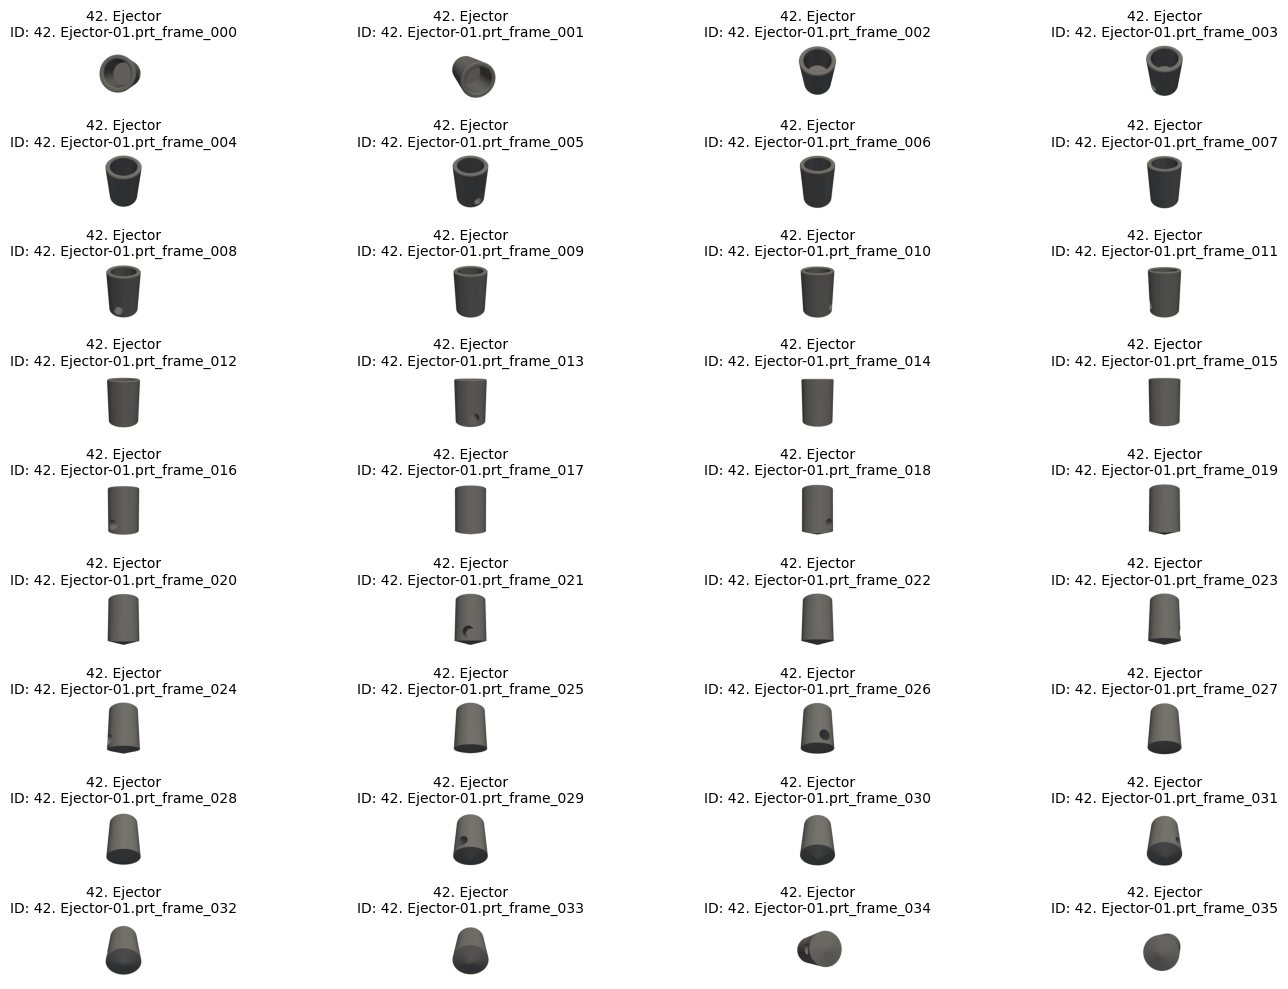

In [22]:
# отобразим изображения
import matplotlib.pyplot as plt

def show_images(images, titles=None, ids=None, ncols=4, figsize=(16, 10)):
    """
    Отображает изображения в сетке с подписями.
    images: список PIL.Image
    titles: список названий классов (или один класс)
    ids: список id изображений (опционально)
    ncols: количество колонок
    figsize: размер фигуры
    """
    n = len(images)
    nrows = (n + ncols - 1) // ncols
    plt.figure(figsize=figsize)
    for i in range(n):
        plt.subplot(nrows, ncols, i + 1)
        plt.imshow(images[i])
        title = ""
        if titles:
            title += str(titles[i]) if isinstance(titles, list) else str(titles)
        if ids:
            title += f"\nID: {ids[i]}"
        plt.title(title, fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Пример вызова:
model = base_dataset[0]
images = model.get_images()
titles = [model.class_name] * len(images)
ids = [img.image_id for img in model.image_paths]
show_images(images, titles, ids)

2) Извлечение эмбеддингов изображений

Загрузка моделей CLIP отличается от загрузки моделей DINOv2. Для CLIP необходимо использовать специальный класс `CLIPModel`, который загружает как текстовую, так и визуальную модели. В случае DINOv2 достаточно загрузить только визуальную модель через класс `DINOv2Model`.


In [14]:
import src.modeling.clip as clip
import torch
import numpy as np
import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

all_labels = []
all_features = []
for model_data in tqdm.tqdm(base_dataset, desc="Processing models"):
    features_list = []
    
    for img_data in model_data.get_images():
        img_tensor = preprocess(img_data).unsqueeze(0).to(device)
        with torch.no_grad():
            features = model.encode_image(img_tensor)
        features /= features.norm(dim=-1, keepdim=True)
        features_list.append(features)

    aggregated_features = torch.mean(torch.stack(features_list), dim=0)
    all_labels.append(model_data.class_name)
    all_features.append(aggregated_features)

X = torch.cat(all_features).cpu().numpy()
y = np.array(all_labels)



base = INTERIM_DATA_DIR / 'v1'

save_features(X, y, base / "features_clip_vitb32.npz")

print(f"Extracted features shape: {X.shape}")
print(f"Extracted labels shape: {y.shape}")
print(f"Unique classes: {np.unique(y)}")

Processing models: 100%|██████████| 129/129 [05:07<00:00,  2.38s/it]

Extracted features shape: (129, 512)
Extracted labels shape: (129,)
Unique classes: ['42. Ejector' '42. Silencer Fix' '43. Extractor' '44. Extractor Pin'
 'Затвор' 'Зацеп трубки направляющий' 'Защелка' 'Защелка АК'
 'Камера газовая' 'Кожух' 'Колодка приклада' 'Колодка прицельная']


In [ ]:
import torch
import tqdm
import numpy as np
import torchvision.transforms as transforms


def make_transform(resize_size: int = 224):
    to_tensor = transforms.ToTensor()
    resize = transforms.Resize((resize_size, resize_size), antialias=True)
    normalize = transforms.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225),
    )
    return transforms.Compose([to_tensor, resize, normalize])

# https://github.com/facebookresearch/dinov2
# google vit name
# ViT-Small
# ViT-Base


model_names = [
    "dinov2_vits14",
    "dinov2_vitb14",
]
# facebookresearch/dinov2
# 
model_name = model_names[0]

device = "cuda" if torch.cuda.is_available() else "cpu"
model = torch.hub.load('facebookresearch/dinov2', model_name, pretrained=True).to(device)
model.eval()
transform = make_transform()

all_labels = []
all_features = []

for model_data in tqdm.tqdm(base_dataset, desc="Processing models"):
    features_list = []
    
    for img_data in model_data.get_images():
        img_tensor = transform(img_data).unsqueeze(0).to(device)
        with torch.no_grad():
            with torch.inference_mode():
                with torch.autocast(device):
                    features = model(img_tensor)
                features /= features.norm(dim=-1, keepdim=True)
                features_list.append(features)

    aggregated_features = torch.mean(torch.stack(features_list), dim=0)
    all_labels.append(model_data.class_name)
    all_features.append(aggregated_features)


X = torch.cat(all_features).cpu().numpy()
y = np.array(all_labels)

base = INTERIM_DATA_DIR / 'v2'

save_features(X, y, base / f"features_{model_name}.npz")

print(f"Extracted features shape: {X.shape}")
print(f"Extracted labels shape: {y.shape}")
print(f"Unique classes: {np.unique(y)}")

Using cache found in C:\Users\dev/.cache\torch\hub\facebookresearch_dinov2_main
Processing models: 100%|██████████| 129/129 [21:36<00:00, 10.05s/it]

Extracted features shape: (129, 384)
Extracted labels shape: (129,)
Unique classes: ['42. Ejector' '42. Silencer Fix' '43. Extractor' '44. Extractor Pin'
 'Затвор' 'Зацеп трубки направляющий' 'Защелка' 'Защелка АК'
 'Камера газовая' 'Кожух' 'Колодка приклада' 'Колодка прицельная']


3) Метрики

In [1]:
from src.metrics import get_metrics
import pandas as pd
from src.feature_io import load_features
base = INTERIM_DATA_DIR / 'v1'
all_metrics = []

X, y = load_features(base / "features_dinov2_vits14.npz")
metrics = get_metrics(X, y)
all_metrics.append(metrics)

X, y = load_features(base / "features_dinov2_vitb14.npz")
metrics = get_metrics(X, y)
all_metrics.append(metrics)

X, y = load_features(base / "features_clip_vitb32.npz")
metrics = get_metrics(X, y)
all_metrics.append(metrics)

metrics_df = pd.DataFrame(all_metrics)

print(metrics_df)

ModuleNotFoundError: No module named 'src'

4) Визуализация

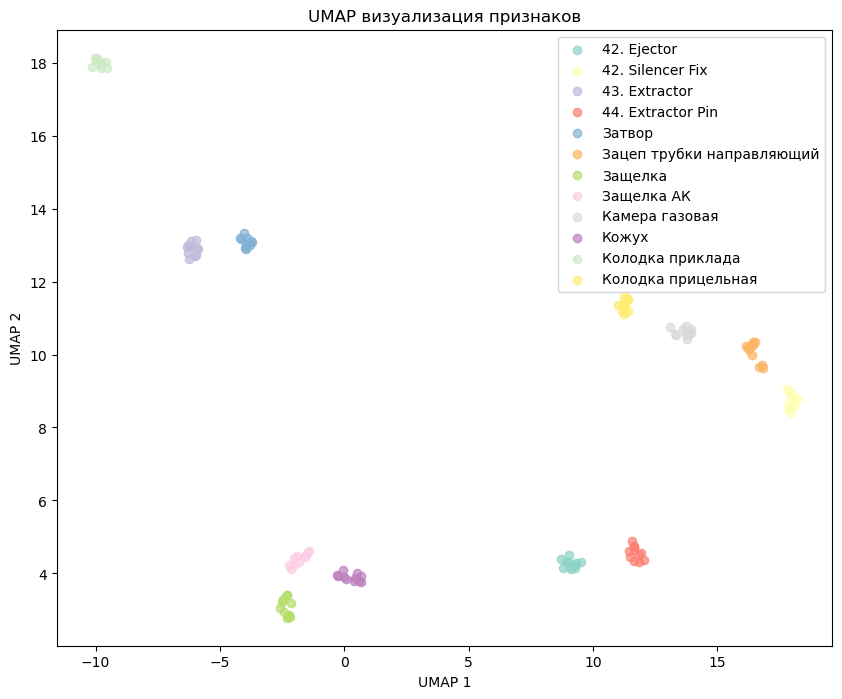

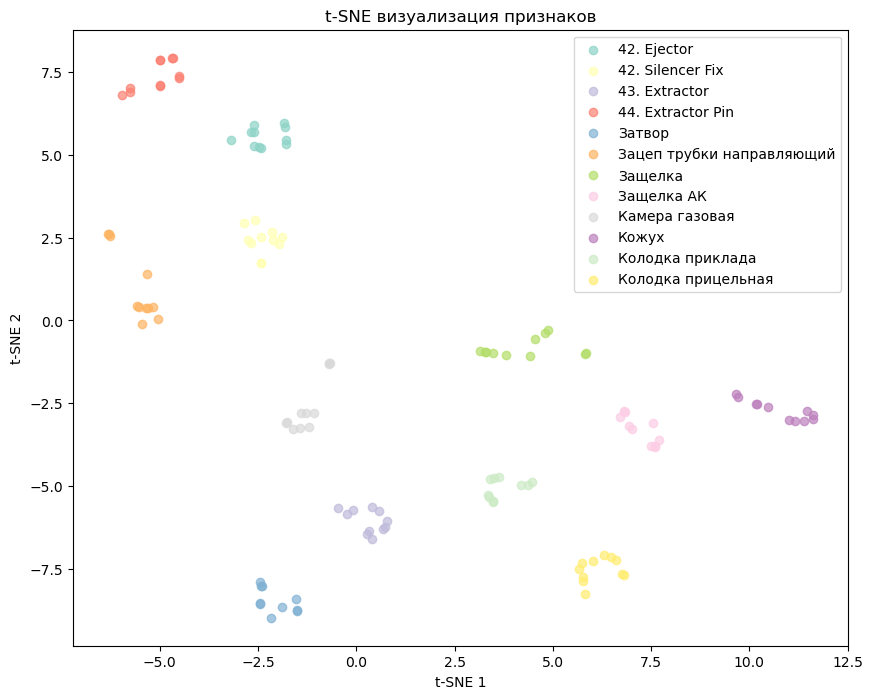

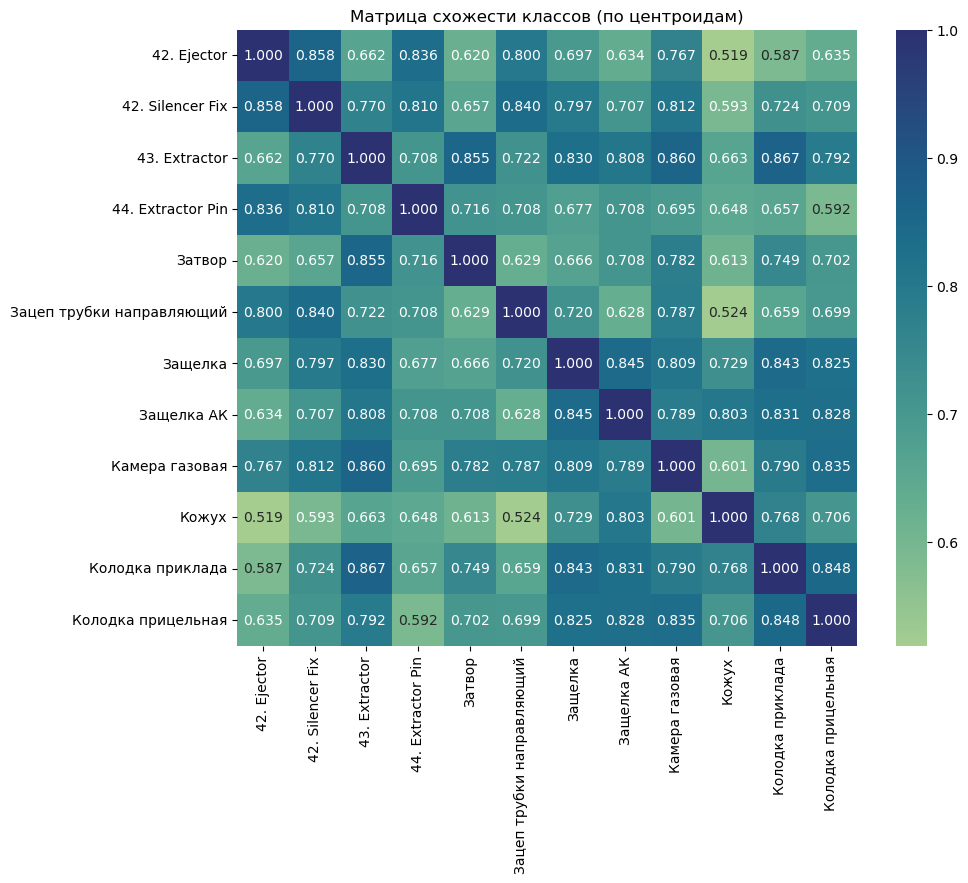

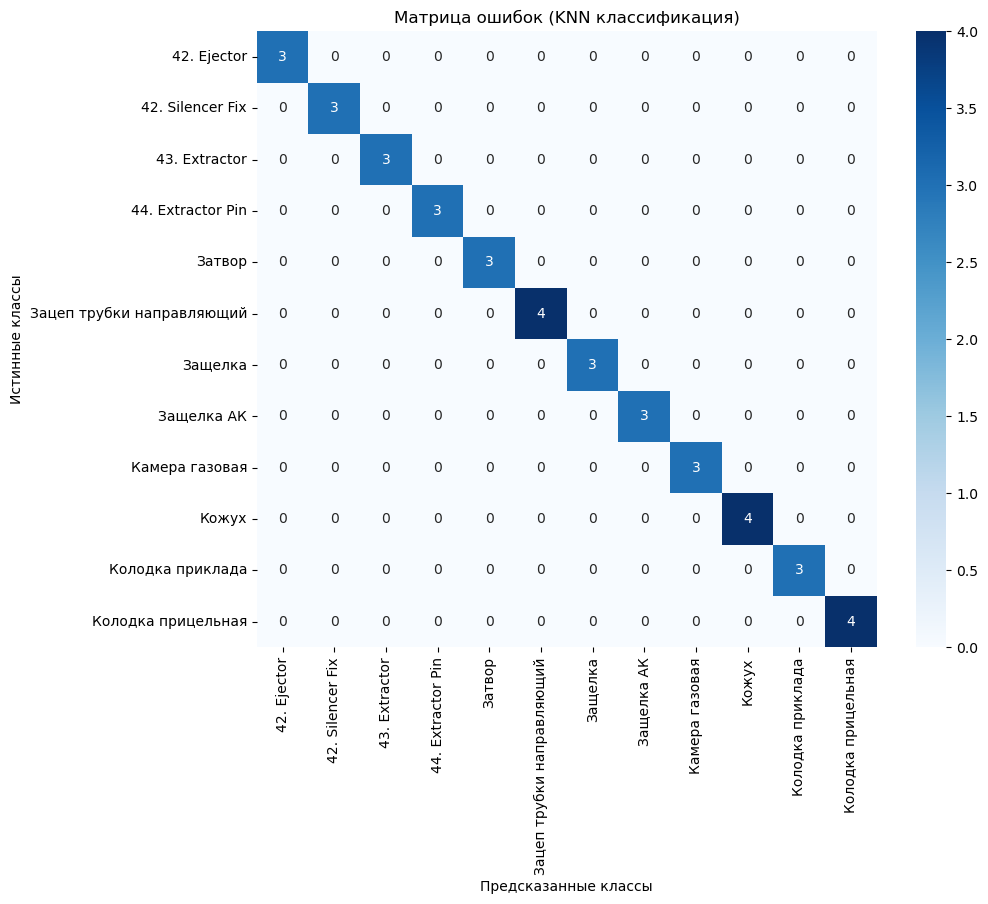

In [29]:
from src.plots import plot_clustering_umap, plot_clustering_tsne, plot_similarity_heatmap, plot_matrix_error
X, y = load_features(base / "features_dinov2_vitb14.npz")
plot_clustering_umap(X, y, None)
plot_clustering_tsne(X, y, None)
plot_similarity_heatmap(X, y, None)
plot_matrix_error(X, y, None)